In [39]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

In [40]:
df = pd.read_csv('Financial_inclusion_dataset.csv')
df.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


In [42]:
df.isna().sum()

country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

In [43]:
df.describe()

,year,household_size,age_of_respondent
count,23524.000000,23524.000000,23524.000000
mean,2016.975939,3.797483,38.805220
std,0.847371,2.227613,16.520569
min,2016.000000,1.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


In [44]:
df.duplicated().sum()

np.int64(0)

In [45]:
# Test multiple models and compare
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Start with XGBoost as primary model
# Use Random Forest for interpretability
# Compare with Logistic Regression as baseline

In [46]:
df.drop(columns=['uniqueid','year'], inplace=True)

In [47]:
X = df.drop(columns=['bank_account'])
Y= df['bank_account']



In [ ]:
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Before train_test_split, fit encoders on full data

# Create le_dict from all categorical columns BEFORE train-test split
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    le.fit(df[col].astype(str))  # Fit on ENTIRE dataframe, not just X_train
    le_dict[col] = le

# Now do train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Then encode using the fitted encoders
for col in cat_cols:
    X_train[col] = le_dict[col].transform(X_train[col].astype(str))
    X_test[col] = le_dict[col].transform(X_test[col].astype(str))


In [51]:
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [52]:
log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train, Y_train)
Y_pred_log = log_reg.predict(X_test)

print(classification_report(Y_test, Y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred_log))  


              precision    recall  f1-score   support

          No       0.95      0.73      0.83      4063
         Yes       0.31      0.77      0.45       642

    accuracy                           0.74      4705
   macro avg       0.63      0.75      0.64      4705
weighted avg       0.87      0.74      0.78      4705

Confusion Matrix:
 [[2975 1088]
 [ 146  496]]


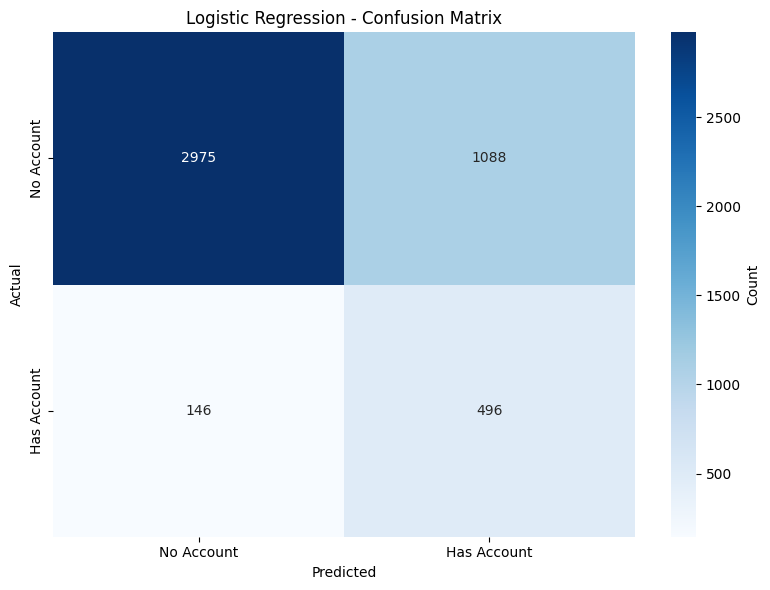

In [53]:

# Logistic Regression Confusion Matrix Visualization
cm_log = confusion_matrix(Y_test, Y_pred_log)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Account', 'Has Account'],
            yticklabels=['No Account', 'Has Account'],
            cbar_kws={'label': 'Count'})
plt.title('Logistic Regression - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


In [54]:


# Encode target variable for XGBoost to work properly
le_target = LabelEncoder()
Y_train = le_target.fit_transform(Y_train)
Y_test = le_target.transform(Y_test)

from xgboost import XGBClassifier
xgb = XGBClassifier(scale_pos_weight=6, random_state=42)
xgb.fit(X_train, Y_train)
Y_pred_xgb = xgb.predict(X_test)

print(classification_report(Y_test, Y_pred_xgb))

              precision    recall  f1-score   support

           0       0.95      0.83      0.88      4063
           1       0.39      0.70      0.50       642

    accuracy                           0.81      4705
   macro avg       0.67      0.77      0.69      4705
weighted avg       0.87      0.81      0.83      4705



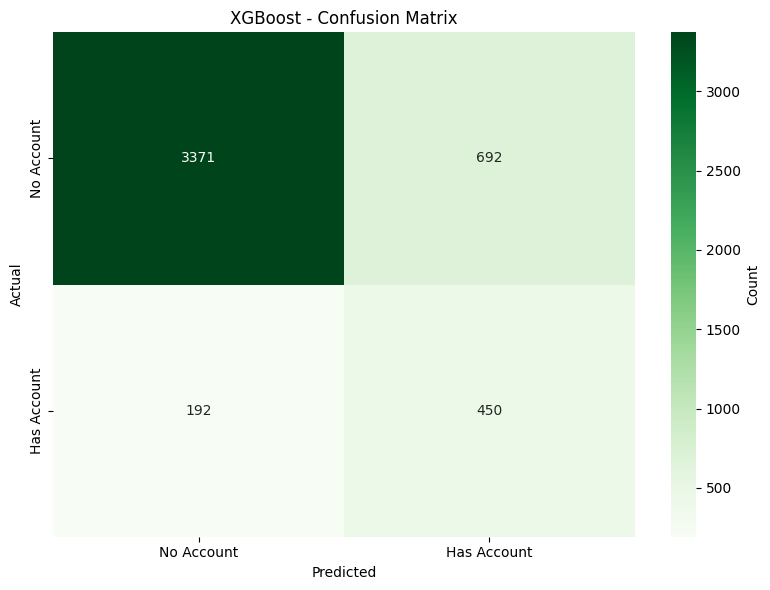

In [55]:

# XGBoost Confusion Matrix Visualization
cm_xgb = confusion_matrix(Y_test, Y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No Account', 'Has Account'],
            yticklabels=['No Account', 'Has Account'],
            cbar_kws={'label': 'Count'})
plt.title('XGBoost - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


In [56]:
#Testing out Random Forest as well for interpretability and comparison 
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train, Y_train)
Y_pred_rf = rf.predict(X_test)

print(classification_report(Y_test, Y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred_rf))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      4063
           1       0.46      0.39      0.42       642

    accuracy                           0.85      4705
   macro avg       0.68      0.66      0.67      4705
weighted avg       0.85      0.85      0.85      4705

Confusion Matrix:
 [[3769  294]
 [ 390  252]]


In [ ]:
import pickle

# After training all models, save them
with open('models.pkl', 'wb') as f:
    pickle.dump({
        'log_reg': log_reg,
        'rf': rf,
        'xgb': xgb,
        'scaler': scaler,
        'le_dict': le_dict,
        'le_target': le_target,
        'Y_pred_log': Y_pred_log,
        'Y_pred_rf': Y_pred_rf,
        'Y_pred_xgb': Y_pred_xgb,
        'Y_test': Y_test
    }, f)